In [100]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [68]:
import rerun as rr
rr.init("demo.py")
rr.connect("127.0.0.1:8812")

In [4]:
xs = jnp.arange(0,51)
ys = jnp.arange(0,51)

In [7]:
x_grid, y_grid = jnp.meshgrid(xs, ys)

In [36]:
p0x, p0y, p0z = 0, 0, 200
n = jnp.array([0,0,1])
nx, ny, nz = n
f = 20

In [21]:
jnp.dstack((x_grid[0:50,0:50], y_grid[0:50,0:50])).shape

(50, 50, 2)

In [27]:
a_s = jnp.dstack((x_grid[0:50,0:50], y_grid[0:50,0:50])).reshape(-1,2)
b_s = jnp.dstack((x_grid[1:51,0:50], y_grid[1:51,0:50])).reshape(-1,2)
c_s = jnp.dstack((x_grid[0:50,1:51], y_grid[0:50,1:51])).reshape(-1,2)
d_s = jnp.dstack((x_grid[1:51,1:51], y_grid[1:51,1:51])).reshape(-1,2)

In [30]:
jnp.stack((a_s,b_s,c_s,d_s), axis=1).shape

(2500, 4, 2)

In [41]:
twoDpoints = jnp.stack((a_s,b_s,c_s,d_s), axis=1)

In [35]:
# linear system solver for triangle pose to 
# px / f = x / z
# py / f = y / z
# nx * (x - p0x) + ny * (y - p0y) + nz * (z - p0z) = 0 

# -x * f + px * z= 0
# -y * f + py * z= 0
# nx * (x - p0x) + ny * (y - p0y) + nz * (z - p0z) = 0 

def solve_3d_from_2d(px, py, p0x, p0y, p0z, nx, ny, nz, f):
    A = jnp.array([[-f, 0, px],
                   [0, -f, py],
                   [nx, ny, nz]])
    b = jnp.array([nx * p0x, ny * p0y, nz * p0z])
    return jnp.linalg.solve(A, b)


In [37]:
px, py = 15, 15
solve_3d_from_2d(px, py, p0x, p0y, p0z, nx, ny, nz, f)

Array([150., 150., 200.], dtype=float32)

In [112]:
def wrap_solve(point):
    px, py = point
    p0x, p0y, p0z = 0, 0, 200
    n = jnp.array([0.2,0.5,1])
    nx, ny, nz = n
    f = 20
    return solve_3d_from_2d(px, py, p0x, p0y, p0z, nx, ny, nz, f)

In [113]:
map_solve = jax.vmap(jax.vmap(wrap_solve))

In [114]:
twoDpoints.shape

(2500, 4, 2)

In [115]:
out_cloud = map_solve(twoDpoints)

In [116]:
def calculate_area(points):
    a, b, c, d = points
    ab = b-a
    ac = c-a
    ad = d-a
    area = 1/2 * (jnp.linalg.norm(jnp.cross(ab,ac)) + jnp.linalg.norm(jnp.cross(ac,ad)))
    return area

mapped_area = jax.vmap(calculate_area, in_axes=(0))

In [117]:
out_cloud.shape

(2500, 4, 3)

In [118]:
out_area = mapped_area(out_cloud)

In [119]:
out_area = out_area.reshape((50,50))

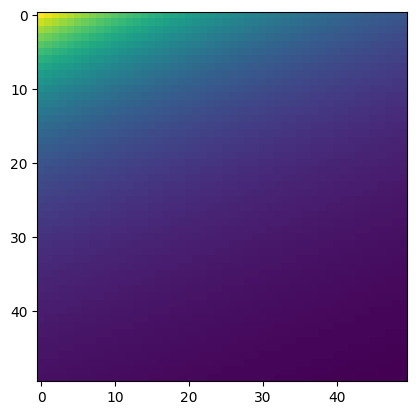

In [120]:
plt.imshow(out_area)

In [121]:
rr.log(
    '/log_cloud',
    rr.Points3D(out_cloud.reshape(-1,3))
)

In [122]:
# appproximate surface normal since no real triangle

In [123]:
# from pc points, get triangle and normal
# normal is cross product of two vectors on edges


In [ ]:
# depth at centroid of triangle (axis mean for x, y, z)
